# Business Text Analysis

_You shall know a word by the company it keeps_ - J. R. Firth

Concepts:
- Syntactic analysis of text
- Density-based Clustering

References:
- Greg Durrett, 2023, "CS388 Natural Language Processing course materisl", retrieved from https://www.cs.utexas.edu/~gdurrett/courses/online-course/materials.html



In [1]:
import re
import numpy as np
from scipy import spatial
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import spacy
from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
from finds.database import SQL, RedisDB
from finds.structured import CRSP, BusDay
from finds.unstructured import Edgar
from finds.utils import Store, Finder, ColorMap
from secret import credentials, paths
# %matplotlib qt
VERBOSE = 0

In [2]:
sql = SQL(**credentials['sql'], verbose=VERBOSE)
user = SQL(**credentials['user'], verbose=VERBOSE)
bd = BusDay(sql)
rdb = RedisDB(**credentials['redis'])
crsp = CRSP(sql, bd, rdb, verbose=VERBOSE)
ed = Edgar(paths['10X'], zipped=True, verbose=VERBOSE)
store = Store(paths['scratch'])
find = Finder(sql)

Last FamaFrench Date 2024-04-30 00:00:00


Retrieve investment universe as of end-2022: we shall subset on the largest decile (based on NYSE market cap breakpoint).

Also, enable lookup of company names and tickers, for readability

In [3]:
# Retrieve universe of stocks, keep to decile
univ = crsp.get_universe(bd.endmo(20221231))
comnam = crsp.build_lookup('permno', 'comnam', fillna="")  # company name
univ['comnam'] = comnam(univ.index)
ticker = crsp.build_lookup('permno', 'ticker', fillna="")  # tickers
univ['ticker'] = ticker(univ.index)

Retrieve Business Description text from 10-K archive

In [4]:
# retrieve 2023 bus10K's
item, form = 'bus10K', '10-K'
rows = DataFrame(ed.open(form=form, item=item))
found = rows[rows['permno'].isin(univ.index[univ.decile <= 1])  # largest decile only
             & rows['date'].between(20230101, 20231231)]\
             .drop_duplicates(subset=['permno'], keep='last')\
             .set_index('permno')

## Syntactic analysis

This involves analyzing the syntactic roles of words in sentences and how they combine to form phrases and sentences according to the rules of a formal grammar. It seems to model the relationships between words and phrases, such as subject-verb-object relationships, which forms the basis for NLP tasks such as dependency or constituent parsing.

### SpaCy

spaCy is a popular open-source library for advanced natural language processing (NLP) tasks in Python, such as POS tagging, entity recognition and dependency parsing. It also offers pre-trained models for various languages and domains, as well as customizable pipelines for processing text data. 

- https://spacy.io/models


In [5]:
# ! python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_lg")

### Lemmatization 

To lemmatize a word is to reduce it to its base or dictionary form, known as the lemma, which represents its morphological root.


In [6]:
# Using spaCy pipeline to tokenize NVIDIA's 10-K business description text
nvidia = find('NVIDIA')['permno'].iloc[0]
doc = nlp(ed[found.loc[nvidia, 'pathname']][:nlp.max_length].lower())
tokens = DataFrame.from_records([{'text': token.text,
                                  'lemma': token.lemma_,
                                  'alpha': token.is_alpha,
                                  'stop': token.is_stop,
                                  'punct': token.is_punct}
                                 for token in doc], index=range(len(doc)))
tokens.head(30)

,text,lemma,alpha,stop,punct
0,item,item,True,False,False
1,1,1,False,False,False
2,.,.,False,False,True
3,business,business,True,False,False
4,\n\n,\n\n,False,False,False
5,our,our,True,True,False
6,company,company,True,False,False
7,\n\n,\n\n,False,False,False
8,nvidia,nvidia,True,False,False
9,pioneered,pioneer,True,False,False


### Part-of-speech tagging

Part-of-speech (POS) tagging is the process of automatically assigning grammatical categories (such as noun, verb, adjective, etc.) to words in a text corpus. This helps in understanding the structure of sentences and extracting meaning from text by identifying the roles that words play in a sentence.


In [7]:
tags = DataFrame.from_records([{'text': token.text,
                                'pos': token.pos_,
                                'tag': token.tag_,
                                'dep': token.dep_}
                                 for token in doc], index=range(len(doc)))
tags.head(30)

,text,pos,tag,dep
0,item,NOUN,NN,ROOT
1,1,NUM,CD,nummod
2,.,PUNCT,.,punct
3,business,NOUN,NN,nsubj
4,\n\n,SPACE,_SP,dep
5,our,PRON,PRP$,poss
6,company,NOUN,NN,appos
7,\n\n,SPACE,_SP,dep
8,nvidia,PROPN,NNP,appos
9,pioneered,VERB,VBD,ROOT


### Named entity recognition

Named Entity Recognition (NER) involves identifying and classifying entities (i.e. real-world objects such as persons, organizations, locations, dates, etc.) from a text corpus. Its goal is to locate and classify named entities in the text into predefined categories, such as organizations or persons.

In [8]:
ents = DataFrame.from_records([{'text': ent.text,
                                'label': ent.label_,
                                'start': ent.start_char,
                                'end': ent.end_char}
                               for ent in doc.ents], index=range(len(doc.ents)))
ents.head(20)

,text,label,start,end
0,1,CARDINAL,5,6
1,nvidia,ORG,357,363
2,gpu,ORG,382,385
3,av,ORG,515,517
4,gpu,ORG,576,579
5,today,DATE,684,689
6,thousands,CARDINAL,835,844
7,gpu,ORG,1115,1118
8,thousands,CARDINAL,1161,1170
9,gpu,ORG,1325,1328


In [9]:
# Entity Visualizer
from spacy import displacy
displacy.render(doc[:300], style="ent", jupyter=True)

### Dependency parsing

Dependency parsing determines the grammatical relationships between words in a sentence. It identifies the dependencies between words, where each word is treated as a node, and the relationships between them are represented as directed edges.  Hence the output of dependency parsing is a tree structure, where each word (except the root) is governed by another word (its head), indicating the syntactic role of each word (e.g., subject, object, modifier) in relation to other words in the sentence.

Transition-based parsing algorithms uses a set of transition operations (e.g. shift, reduce) to incrementally build a dependency tree from an input sentence.


In contrast, __constituent parsing__ focuses on identifying and representing the _hierarchical structure of phrases_ in a sentence according to a formal grammar. It groups words into nested syntactic units (e.g., noun phrases, verb phrases), typically as a tree structure (called a parse tree or constituent tree) where each node represents a constituent phrase and its children represent the words or smaller constituents that form it. The CKY (Cocke-Kasami-Younger) algorithm is a dynamic programming technique for parsing sentences and constructing parse trees.

__Probabilistic Context-Free Grammar (PCFG)__ extends assigns probabilities to the production rules of a standard Context-Free Grammar (CFG). Each production rule defines how non-terminal symbols (such as NP for noun phrase or VP for verb phrase) can be expanded into sequences of terminal symbols (words) or other non-terminals. The probability associated with each rule indicates the likelihood of using that rule in generating or parsing sentences. 

The training of models for automatic tagging and parsing relies on labeled data from __treebanks__, which are collections of parsed sentences where each sentence has been annotated with its grammatical structure showing how words are grouped into phrases and how these phrases relate to each other through syntactic dependencies.  The __Penn Treebank__ is one of the earliest and most widely used treebanks for English: it includes syntactic annotations such as part-of-speech tags and parse trees.


In [20]:
sentence_spans = list(doc.sents)
displacy.render(sentence_spans[2:4], style="dep", jupyter=True, 
                options=dict(compact=False, distance=175))

### Word vectors

Word embeddings are numerical representations of words in a multidimensional space, created to help capture the relationships and meanings of words. Word embeddings achieve this by mapping words into a high-dimensional space, where the positions of the words reflect their syntactical and semantic similarities based on how often they co-occur within a large corpus.

For example, spaCy's `en_core_web_lg` model represents each of some 500K+ words in its vocabulary with a unique 300-dimensional vector.


Use the POS tagger in the spaCy pipeline to extract the lemmatized form of nouns from business descriptions text

In [ ]:
# Extract nouns
bus = {}
for permno in tqdm(found.index):
    doc = nlp(ed[found.loc[permno, 'pathname']][:nlp.max_length].lower())
    nouns = " ".join([re.sub("[^a-zA-Z]+", "", token.lemma_) for token in doc
                      if token.pos_ in ['NOUN'] and len(token.lemma_) > 2])
    if len(nouns) > 100:
        bus[permno] = nouns        
store['business'] = bus


In [18]:
bus = store.load('business')
permnos = list(bus.keys())
tickers = univ.loc[permnos, 'ticker'].to_list()

Show the average word vector value for NVidia's business description text. 

In [19]:
# example of word vector
vec1 = nlp(bus[nvidia]).vector
vec1

array([-0.5370803 ,  0.03360266, -0.7142777 ,  1.0528733 ,  2.59639   ,
        0.29917082,  1.3443472 ,  3.7829578 , -2.2698855 , -1.2616774 ,
        5.9859304 ,  2.0566463 , -4.519684  ,  2.2885911 , -1.1176012 ,
        2.4155278 ,  3.2593274 ,  1.5960239 , -2.3042047 ,  0.06216303,
        0.21148767,  1.7382729 , -2.3506453 ,  0.7941269 , -1.2192215 ,
       -1.8039206 , -1.8674678 , -1.6660213 , -0.7127941 ,  1.0603017 ,
        1.2367841 ,  1.2303644 , -1.1252155 , -0.44499   ,  0.34517637,
       -0.38984352,  1.4724953 ,  0.7678367 ,  1.3465229 ,  0.35140815,
        0.2309201 , -0.14058447,  0.18483874,  0.99899405, -1.4584388 ,
        1.5930446 ,  2.0110247 , -1.9788889 ,  0.49480593, -1.2044214 ,
        0.11300751,  2.2886782 , -0.19940257, -3.7744892 , -0.5143599 ,
        0.5165942 , -1.6783403 ,  1.471545  ,  0.44622797, -1.4958122 ,
        2.2605124 ,  1.2073922 , -2.2683856 , -1.2163076 ,  2.4330237 ,
        1.984873  , -2.2740626 , -3.403873  ,  0.47273394,  2.99

Compute average word vector value for all companies' business description text

In [ ]:
# Compute sentence vectors
vecs = np.array([nlp(bus[permno]).vector for permno in bus.keys()])
store['vectors'] = vecs


In [20]:
vecs = store['vectors']

In [21]:
# Distance matrix
n = len(bus)
distances = np.zeros((n, n))
for row in range(n):
    for col in range(row, n):
        distances[row, col] = spatial.distance.cosine(vecs[row], vecs[col])
        distances[col, row] = distances[row, col] 

Show companies with most similar business descriptions, for some selected companies

In [62]:
def most_similar(p):
    dist = distances[permnos.index(p)]
    dist[permnos.index(p)] = max(dist)   # to ignore own distance
    return univ.loc[permnos[np.argmin(dist)]]
for name in ['NVIDIA', 'APPLE COMPUTER', 'JNJ', 'EXXON MOBIL', 'AMERICAN EXPRESS']:
    p = find(name)['permno'].iloc[-1]
    print(f"{most_similar(p)['comnam']}' is most similar to '{name}'")

QUALCOMM INC' is most similar to 'NVIDIA'
MICROSOFT CORP' is most similar to 'APPLE COMPUTER'
PFIZER INC' is most similar to 'JNJ'
PIONEER NATURAL RESOURCES CO' is most similar to 'EXXON MOBIL'
U S BANCORP DEL' is most similar to 'AMERICAN EXPRESS'


## __t-SNE visualization__

T-distributed Stochastic Neighbor Embedding (t-SNE)
is a tool to visualize high-dimensional data. It
converts similarities between data points to joint probabilities and
tries to minimize the Kullback-Leibler divergence between the joint
probabilities of the low-dimensional embedding and the
high-dimensional data. It preserves the local structure of the data in 2D or 3D, ensuring that similar data points are mapped close to each other, which helps in identifying clusters that are not easily observable in higher dimensions.

- https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html


In [32]:
Z = TSNE(n_components=2, perplexity=10, random_state=42)\
    .fit_transform(vecs)

Visualize the business descriptions, reduced to 2D space with the t-SNE technique, with tickers as labels.

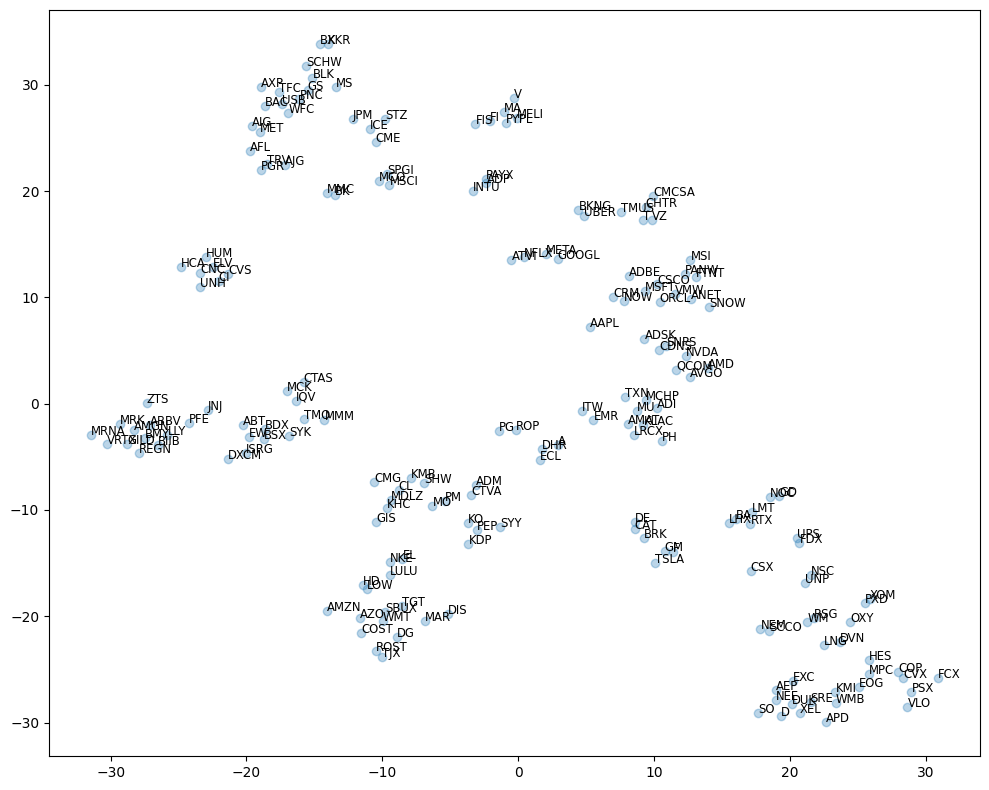

In [26]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(Z[:, 0], Z[:, 1], color="C0", alpha=.3)
for text, x, y in zip(tickers, Z[:, 0], Z[:, 1]):
    ax.annotate(text=text, xy=(x, y), fontsize='small')
plt.tight_layout()

## DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a clustering algorithm
for datasets with intricate cluster shapes and varying densities. It is also robust to noise, by identifying points in low-density areas as outliers. Unlike k-means, it doesn't require a predefined number of clusters, and requires two main parameters: epsilon (ε) and the minimum number of points to form a dense region.


In [61]:
# eps is the most important parameter for DBSCAN
eps = 4
db = cluster.DBSCAN(eps=eps)   # default eps
db.fit(Z)
n_clusters = len(set(db.labels_).difference({-1}))
n_noise = np.sum(db.labels_ == -1)
DataFrame(dict(clusters=n_clusters, noise=n_noise, eps=eps),  index=['DBSCAN'])

,clusters,noise,eps
DBSCAN,9,8,4


Visualize the colored clusters of business descriptions in 2-dimensional space.  Ticker symbols of outliers are displayed with larger font sizes.

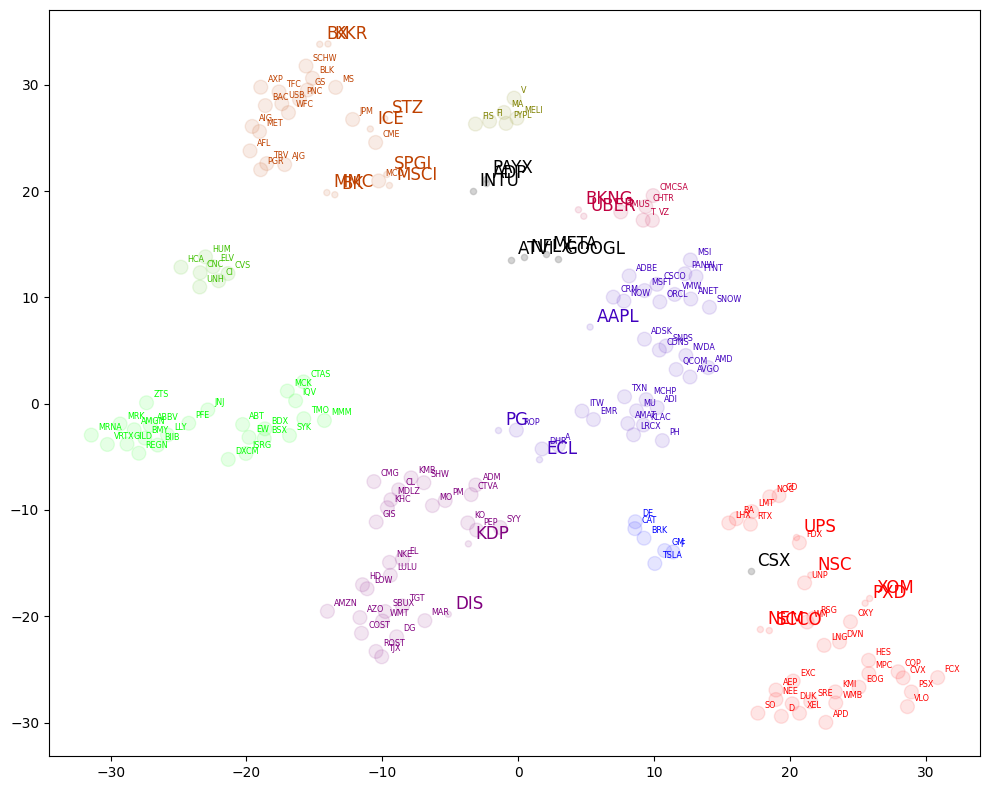

In [58]:
cmap = ColorMap(n_clusters)
fig, ax = plt.subplots(figsize=(10, 8))
# plot core samples with larger marker size
ax.scatter(Z[db.core_sample_indices_, 0],
           Z[db.core_sample_indices_, 1],
           c=cmap[db.labels_[db.core_sample_indices_]],
           alpha=.1, s=100, edgecolors=None)
# plot non-core samples with smaller marker size
non_core = np.ones_like(db.labels_, dtype=bool)
non_core[db.core_sample_indices_] = False
non_core[db.labels_ < 0] = False
ax.scatter(Z[non_core, 0], Z[non_core, 1], c=cmap[db.labels_[non_core]],
           alpha=.1, s=20, edgecolors=None)
# plot noise samples 
ax.scatter(Z[db.labels_ < 0, 0], Z[db.labels_ < 0, 1], c="darkgrey",
           alpha=.5, s=20, edgecolors=None)

# annotate with tickers not in core samples
for i, (t, c, xy) in enumerate(zip(tickers, db.labels_, Z)):
    if i in db.core_sample_indices_:
        ax.annotate(text=t, xy=xy+.5, color=cmap[c], fontsize='xx-small')
    elif c == -1:
        ax.annotate(text=t, xy=xy+.5, color='black', fontsize='large')
    else:
        ax.annotate(text=t, xy=xy+.5, color=cmap[c], fontsize='large')
plt.tight_layout()

In [59]:
print("Samples tagged as noise:")
univ.loc[np.array(permnos)[db.labels_ < 0]].sort_values('naics')

Samples tagged as noise:


,cap,capco,decile,nyse,siccd,prc,naics,comnam,ticker
permno,,,,,,,,,
90319,5.254979e+08,1.055039e+09,1,False,7375,88.23,334419,ALPHABET INC,GOOGL
62148,6.400468e+07,6.400468e+07,1,False,4011,30.98,482111,C S X CORP,CSX
79678,6.003189e+07,6.003189e+07,1,False,7370,76.55,511210,ACTIVISION BLIZZARD INC,ATVI
78975,1.093416e+08,1.093416e+08,1,False,7370,389.22,511210,INTUIT INC,INTU
44644,9.898358e+07,9.898358e+07,1,False,7374,238.86,518210,AUTOMATIC DATA PROCESSING INC,ADP
13407,2.704040e+08,2.704040e+08,1,False,7375,120.34,519190,META PLATFORMS INC,META
89393,1.313239e+08,1.313239e+08,1,False,7841,294.88,532282,NETFLIX INC,NFLX
61621,4.165557e+07,4.165557e+07,1,False,8700,115.56,541219,PAYCHEX INC,PAYX
